# Flux-Balance Analysis (FBA)

following the examples by Daniel Segre in this notebook: https://colab.research.google.com/drive/1quuXRdXa92W3os9oT8aC6N31Pjl-Dhi9?usp=sharing#scrollTo=iRH3cKQ9C_wF

In [21]:
import numpy as np # Imports Python numerical library
import seaborn as sns # Imports Library for drawing heatmaps
import matplotlib.pyplot as plt # Import Library for plotting graphs
from scipy.optimize import linprog # Imports Linear Programming function
from scipy.optimize import linprog_verbose_callback # Imports Linear Programming function

STOICHIOMETRIC MATRIX


<Axes: >

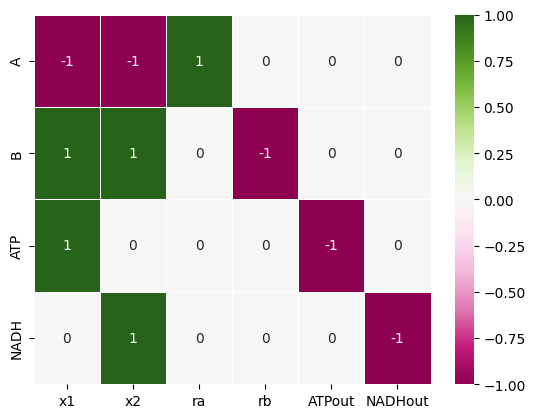

In [2]:
# labels of reactions
reacs = ['x1', 'x2', 'ra', 'rb', 'ATPout', 'NADHout']
# labels of metabolites
metabs = ['A', 'B', 'ATP', 'NADH']

n = len(reacs)  # number of reactions
m = len(metabs) # number of metabolites

# define the stoichometric matrix
S = np.array([[ -1, -1,  1,  0,  0,  0],  # metab A
              [  1,  1,  0, -1,  0,  0],  # metab B
              [  1,  0,  0,  0, -1,  0],  # metab ATP
              [  0,  1,  0,  0,  0, -1]]) # metab NADH

print('STOICHIOMETRIC MATRIX')
# colormap = sns.color_palette('Greens')
sns.heatmap(S, annot=True, linewidth=.5, xticklabels=reacs, yticklabels=metabs, cmap='PiYG')

## define optimization parameters
this includes flux lower bounds (LB), upper bounds (UB), and an objective function

In [3]:
b = np.zeros(m)  # right-hand side of Sv=0
obj = np.zeros(n) # Initialize the objective function vector (the thing we are tring to minimize)
LARGE = 1000 
LB = np.zeros(n)
UB = LARGE * np.ones(n)

# change flow through individual reaction
UB[2] = 1.0

LBUB = np.transpose(np.stack((LB,UB), axis=0))  # combine LB, UB into set of pairs [LB, UB]

obj[0] = -1  # default of optimizer (linprog) is to minimize, so a -1 will lead to maximization
# obj[1] = -1

In [4]:
LBUB

array([[   0., 1000.],
       [   0., 1000.],
       [   0.,    1.],
       [   0., 1000.],
       [   0., 1000.],
       [   0., 1000.]])

In [5]:
obj

array([-1.,  0.,  0.,  0.,  0.,  0.])

## run LP to solve FBA
perform Linear Programming (LP) calculation

In [6]:
print("IMPLEMENT OPTIMIZATION:")
# options
solution = linprog(c=obj, A_eq=S, b_eq=b, bounds=LBUB)

print(f"Optimal value: {solution.fun}")
print(f"Solution vector: {solution.x}")

IMPLEMENT OPTIMIZATION:
Optimal value: -1.0
Solution vector: [ 1.  0.  1.  1.  1. -0.]


In [7]:
# help(linprog)

## display solution

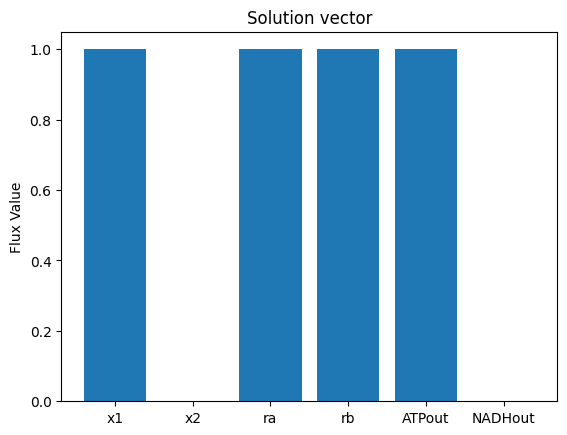

In [8]:
v_pos = np.arange(n)
plt.bar(v_pos, solution.x, align='center')
plt.xticks(v_pos, reacs)
plt.ylabel('Flux Value')
plt.title('Solution vector')
plt.show()

In [9]:
v_pos

array([0, 1, 2, 3, 4, 5])

In [10]:
# help(linprog)

In [11]:
def draw_network(_S,_reacs,_metabs,_solution):

  import networkx as nx
  flux_vec = _solution.x #  flux vector
  thickness_factor = 7
  norm_flux = thickness_factor*flux_vec /max(abs(flux_vec)) # Computes normalized flux vector for drawing network
  G = nx.DiGraph()
  G.add_nodes_from(_metabs)
  G.add_nodes_from(_reacs)
  for col in range(_S.shape[1]): 
    reac_string=_reacs[col] + "[Flux = "+ str(round(flux_vec[col],2)) + "] : "
    curr_col=_S[:, col]
    curr_col_pos= np.where(curr_col > 0)[0] 
    curr_col_neg= np.where(curr_col < 0)[0] 

    if len(curr_col_neg)>0:
      for f in curr_col_neg:
        G.add_edge(_metabs[f],_reacs[col],weight=norm_flux[col])    

    if len(curr_col_pos)>0:
      for f in curr_col_pos:
        G.add_edge(reacs[col],metabs[f],weight=norm_flux[col])

  # pos = nx.spring_layout(G,weight=0)
  pos = nx.kamada_kawai_layout(G,weight=0)
  # pos = nx.circular_layout(G)

  edges = G.edges()
  #colors = [G[u][v]['color'] for u,v in edges]
  weights = [G[u][v]['weight']+0.1 for u,v in edges]

  #nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)
  nx.draw(G, pos, with_labels=True,node_size = 700, node_color=[[0.4, 0.7, 0.9]],width=weights)

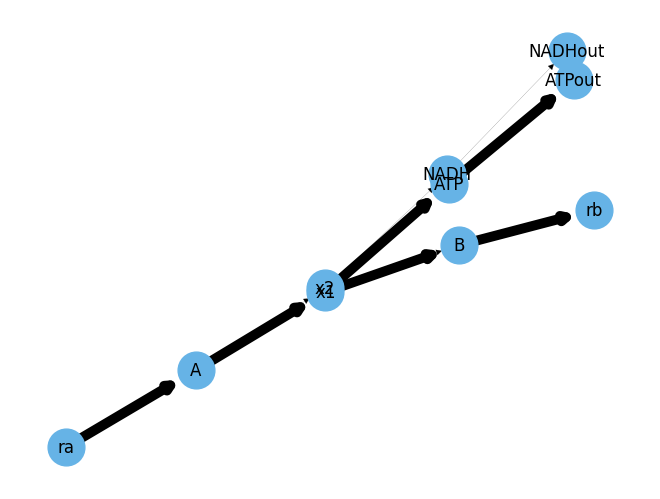

In [12]:
draw_network(S,reacs,metabs,solution)

## check which reactions are non-essential

In [13]:
for i, reac in enumerate(reacs):
    # print(f"INDEX: {i}, REACTION: {reac}")

    # make the FBA problem
    b = np.zeros(m)  # right-hand side of Sv=0
    obj = np.zeros(n) # Initialize the objective function vector (the thing we are tring to minimize)
    LARGE = 1000 
    LB = np.zeros(n)
    UB = LARGE * np.ones(n)
    
    # turn this reaction off
    UB[i] = 0.0
    
    LBUB = np.transpose(np.stack((LB,UB), axis=0))  # combine LB, UB into set of pairs [LB, UB]
    
    obj[3] = -1  # default of optimizer (linprog) is to minimize, so a -1 will lead to maximization

    # solve the problem
    solution = linprog(c=obj, A_eq=S, b_eq=b, bounds=LBUB)

    if solution.fun == 0:
        print(f"REACTION {reac} is essential")
    else:
        print(f"REACTION {reac} is non-essential")
    # print(f"Optimal value: {solution.fun}")
    # print(f"KNOCKOUT REACTION {reac} Solution vector: {solution.x}")


REACTION x1 is non-essential
REACTION x2 is non-essential
REACTION ra is essential
REACTION rb is essential
REACTION ATPout is non-essential
REACTION NADHout is non-essential


## FBA with COBRA

In [1]:
import cobra
from cobra.io import load_model

# load the textbook model
model = load_model("textbook")

In [2]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


In [41]:
r1 = model.reactions[0]
# help(r1)

# for r in model.reactions:
#     stoich = ''
#     for met, coeff in r.metabolites.items():
#         stoich += f"{met}: {coeff}, "
#     print(f"{r.id}: {stoich}")

In [42]:
r1

Reaction identifier,ACALD
Name,acetaldehyde dehydrogenase (acetylating)
Memory address,0x28767dca0
Stoichiometry,acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c Acetaldehyde + Coenzyme A + Nicotinamide adenine dinucleotide <=> Acetyl-CoA + H+ + Nicotinamide adenine dinucleotide - reduced
GPR,b0351 or b1241
Lower bound,-1000.0
Upper bound,1000.0


In [26]:
# model.metabolites

In [22]:
# get stoichiometric matrix
S = cobra.util.create_stoichiometric_matrix(model, 'DataFrame')

<Axes: >

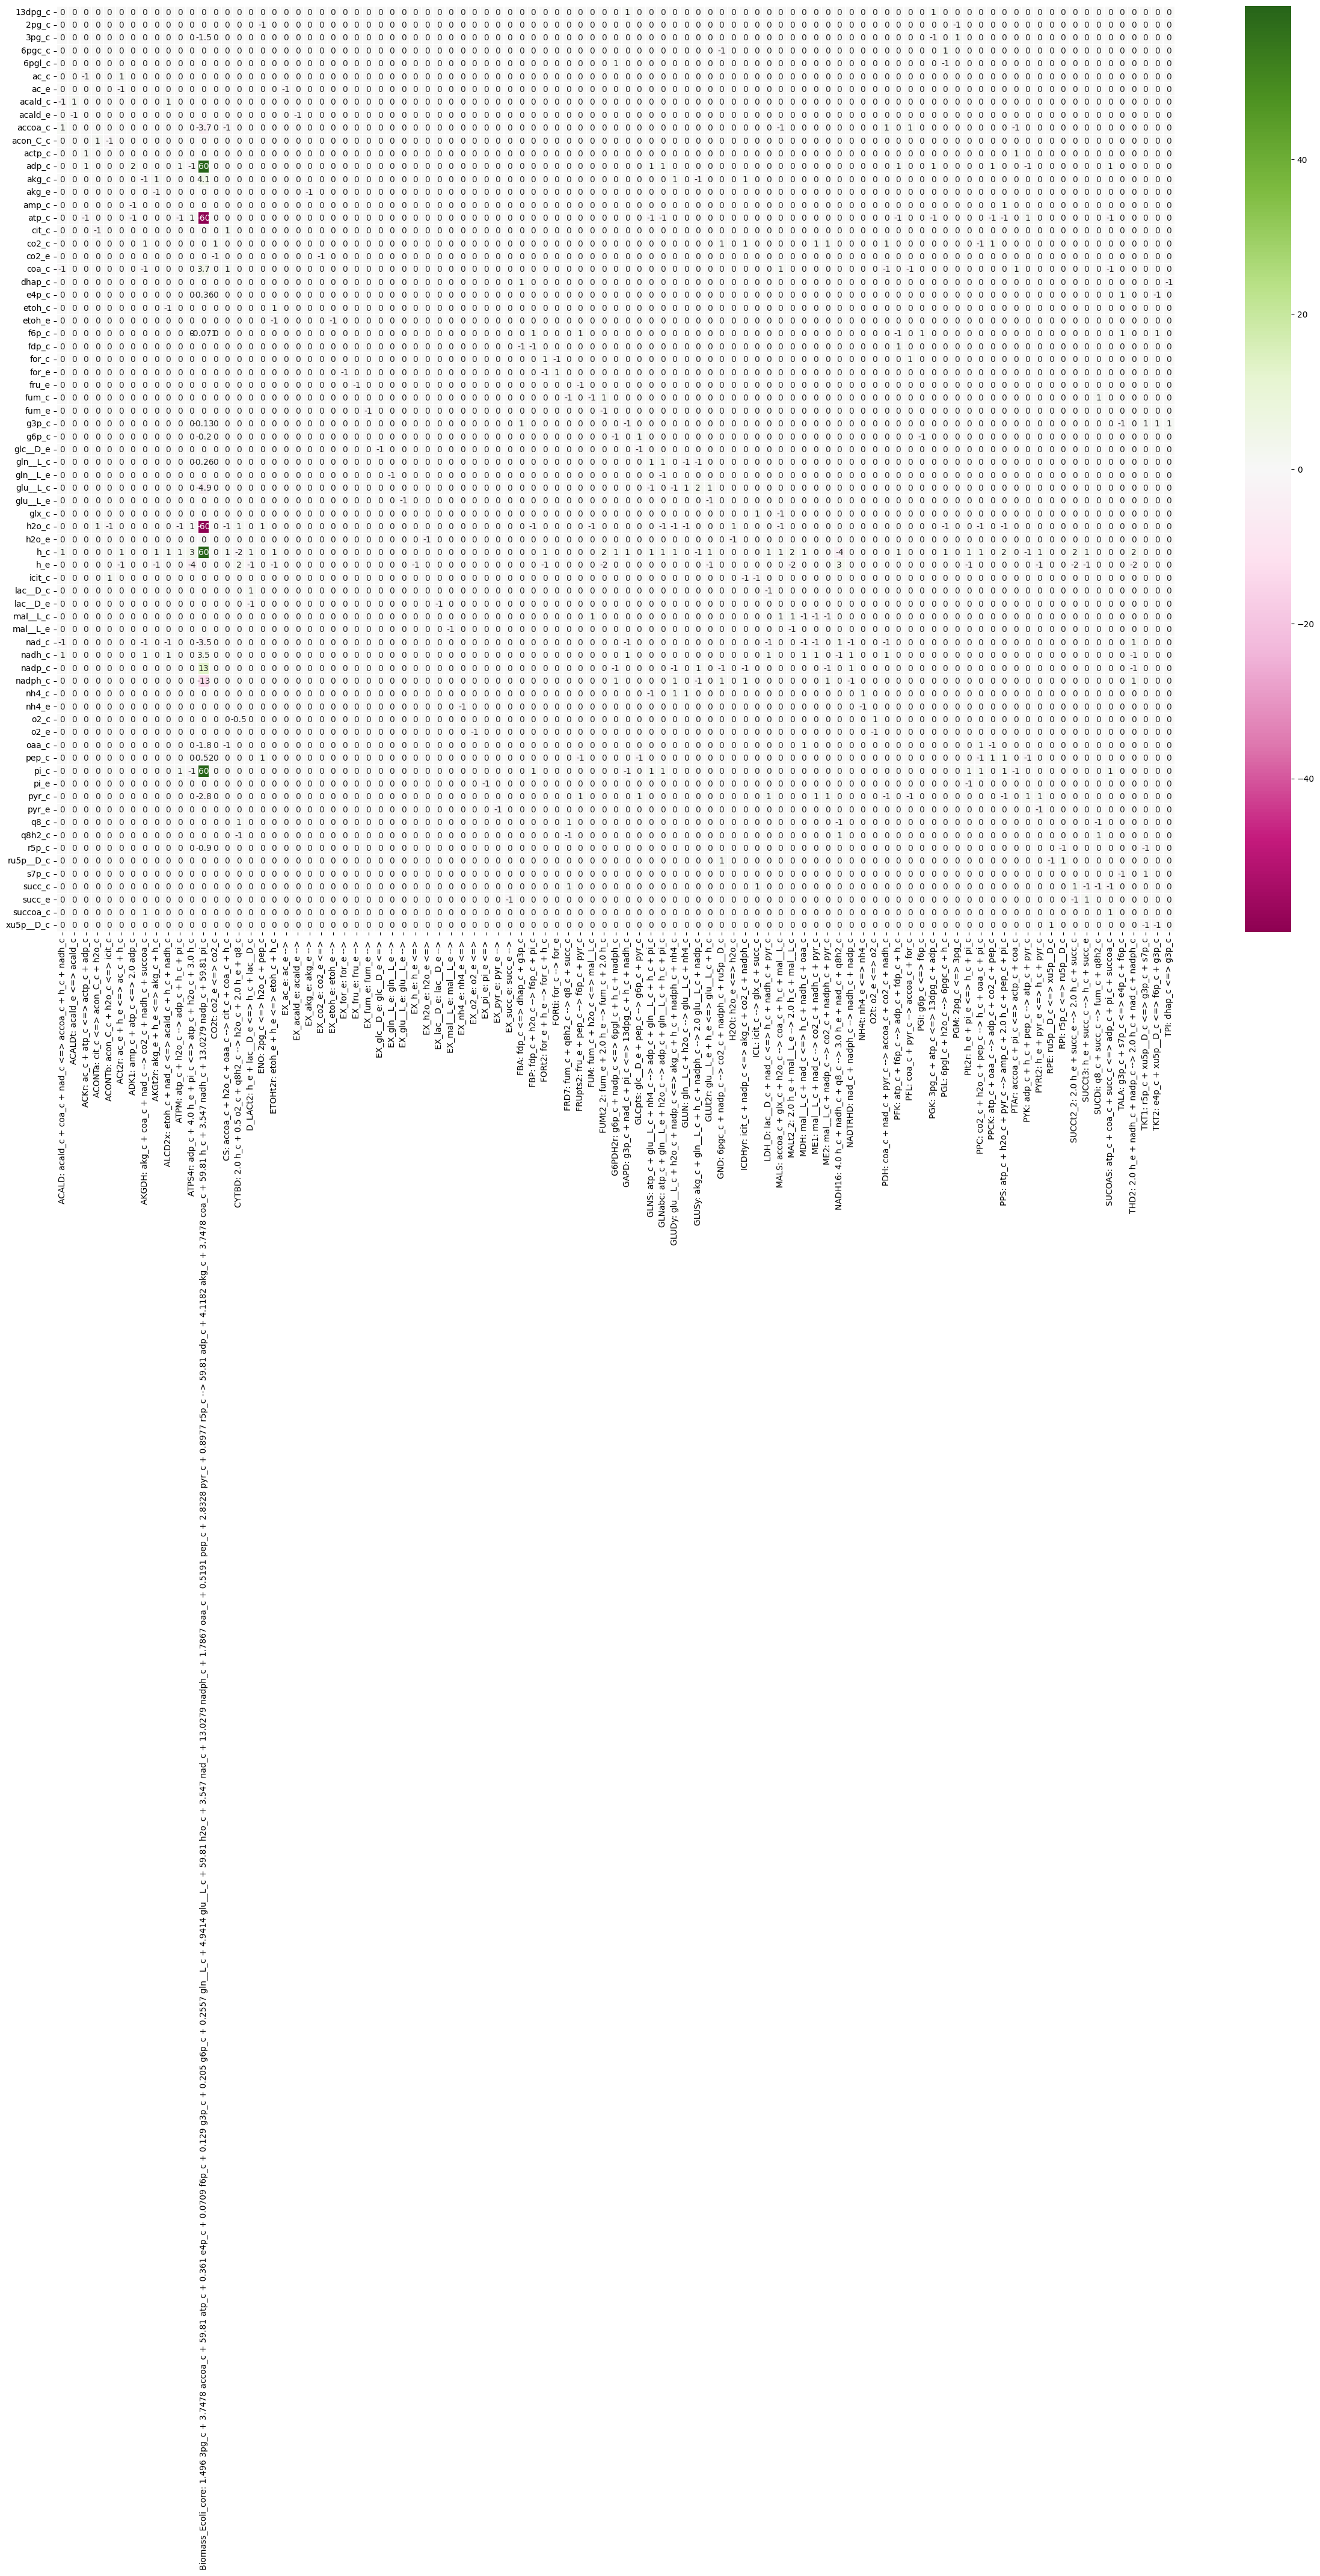

In [23]:
plt.subplots(figsize=(30,20))
sns.heatmap(S, annot=True, 
            linewidth=.1, 
            xticklabels=model.reactions, 
            yticklabels=model.metabolites, 
            cmap='PiYG')

In [32]:
model.reactions.EX_o2_e.bounds

(-1000.0, 1000.0)

In [26]:
solution = model.optimize()

In [27]:
solution

,fluxes,reduced_costs
ACALD,6.379285e-15,3.864368e-18
ACALDt,0.000000e+00,-0.000000e+00
ACKr,1.401836e-14,-0.000000e+00
ACONTa,6.007250e+00,-1.196989e-16
ACONTb,6.007250e+00,-1.236598e-16
...,...,...
TALA,1.496984e+00,3.173170e-17
THD2,0.000000e+00,-2.546243e-03
TKT1,1.496984e+00,6.380927e-18
TKT2,1.181498e+00,1.586585e-17


In [28]:
solution.fluxes['EX_o2_e']

-21.79949265599882

In [55]:
# help(solution)

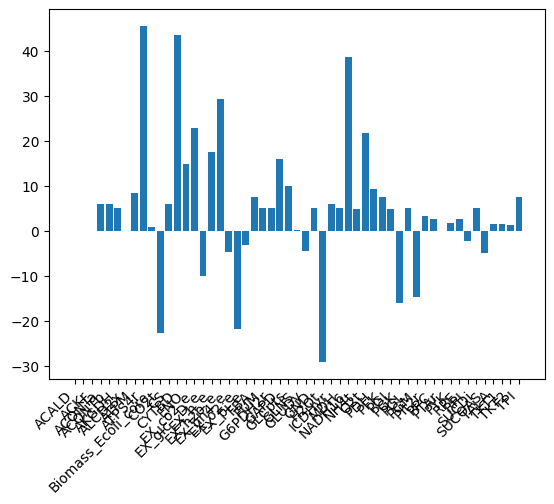

In [29]:
# fluxes = solution.fluxes
reac_names = [
    r.id if solution.fluxes[r.id] !=0 else "" 
    for r in model.reactions 
]
fig = plt.figure()
plt.bar(reac_names, solution.fluxes)
plt.xticks(rotation=45, ha="right")
plt.show()

In [64]:
# get all exchange reactions based on their id, assuming they all start with EX_

exchange_reactions_ids = []
for r in model.reactions:
    r_id = r.id
    if 'EX_' in r_id:
        exchange_reactions_ids.append(r_id)

exchange_reactions_ids

['EX_ac_e',
 'EX_acald_e',
 'EX_akg_e',
 'EX_co2_e',
 'EX_etoh_e',
 'EX_for_e',
 'EX_fru_e',
 'EX_fum_e',
 'EX_glc__D_e',
 'EX_gln__L_e',
 'EX_glu__L_e',
 'EX_h_e',
 'EX_h2o_e',
 'EX_lac__D_e',
 'EX_mal__L_e',
 'EX_nh4_e',
 'EX_o2_e',
 'EX_pi_e',
 'EX_pyr_e',
 'EX_succ_e']

In [86]:
import copy

In [103]:
n_points = 20
original_lb = -1000
O2vec = np.linspace(0,40, n_points)                # vectore of o2 levels
vgro = np.zeros(O2vec.size)                        # initalize vector of growth rates
model.reactions.EX_o2_e.lower_bound = original_lb  # set the baseline o2 bound
exchange_fluxes = {
    r_id: np.zeros(O2vec.size) 
    for r_id in exchange_reactions_ids
}

# go through each o2 level and get solution
for index, o2_level in enumerate(O2vec):

    # change the environment according to o2 level
    model.reactions.EX_o2_e.lower_bound = - o2_level

    # run FBA
    solution = model.optimize()

    # save the solutions
    vgro[index] = solution.objective_value
    for r_id in exchange_reactions_ids:
        exchange_fluxes[r_id][index] = solution.fluxes[r_id]

# return model to original bounds
model.reactions.EX_o2_e.lower_bound = original_lb

In [97]:
# exchange_fluxes

In [98]:
original_lb

-1000

In [99]:
baseline_soln.fluxes['EX_o2_e']

-21.799492655998773

Text(0.5, 0, 'oxygen level')

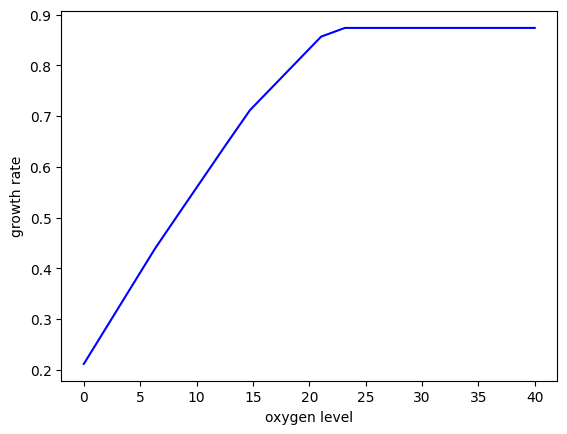

In [100]:
# plot
ax = plt.subplot(111)
ax.plot(O2vec,vgro,'b')
ax.set_ylabel('growth rate')
ax.set_xlabel('oxygen level')

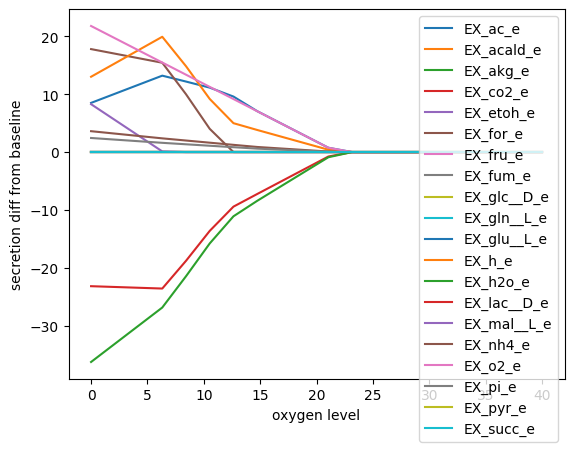

In [102]:
# plot
ax = plt.subplot(111)
for r_id in exchange_reactions_ids:
    ax.plot(O2vec,exchange_fluxes[r_id], label=r_id)
ax.set_ylabel('secretion diff from baseline')
ax.set_xlabel('oxygen level')
ax.legend()

In [49]:
n_points = 20
O2vec = np.linspace(0,40, n_points)
vgro = np.zeros(O2vec.size)  # initalize vector of growth rates
vacet = np.zeros(O2vec.size) # vector of acetate flux
original_lb = model.reactions.EX_o2_e.lower_bound  # original lower bound

for index, o2_level in enumerate(O2vec):
    model.reactions.EX_o2_e.lower_bound = - o2_level

    # run FBA
    solution = model.optimize()
    vgro[index] = solution.objective_value
    vacet[index] = solution.fluxes.EX_ac_e

model.reactions.EX_o2_e.lower_bound = original_lb

Text(0.5, 0, 'oxygen level')

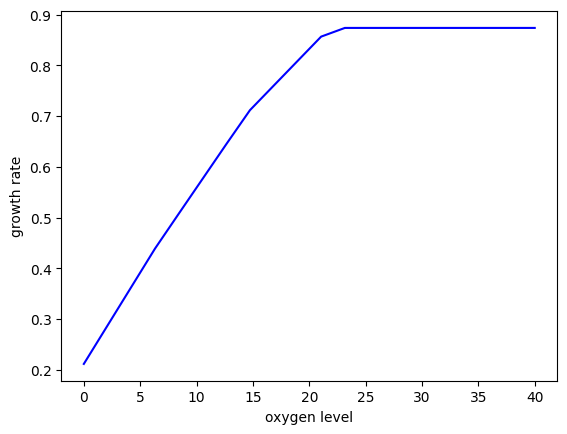

In [52]:
# plot
ax = plt.subplot(111)
ax.plot(O2vec,vgro,'b')
ax.set_ylabel('growth rate')
ax.set_xlabel('oxygen level')

In [55]:
vacet

array([ 8.50358528, 10.07307517, 11.64256507, 13.21205496, 12.19227725,
       11.140248  ,  9.5966594 ,  7.07470005,  4.96584513,  2.85699021,
        0.74813529,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

Text(0.5, 0, 'oxygen level')

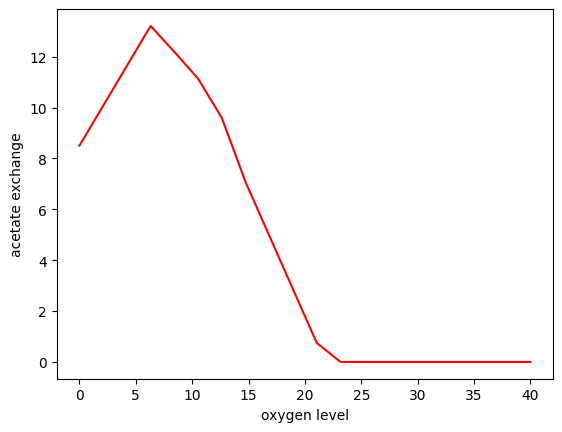

In [54]:
# plot
ax = plt.subplot(111)
ax.plot(O2vec,vacet,'r')
ax.set_ylabel('acetate secretion')
ax.set_xlabel('oxygen level')

In [58]:
r1 = model.reactions.get_by_id('EX_ac_e')

r1
# help(r1)

# for r in model.reactions:
#     stoich = ''
#     for met, coeff in r.metabolites.items():
#         stoich += f"{met}: {coeff}, "
#     print(f"{r.id}: {stoich}")

Reaction identifier,EX_ac_e
Name,Acetate exchange
Memory address,0x287698e50
Stoichiometry,ac_e --> Acetate -->
GPR,
Lower bound,0.0
Upper bound,1000.0


O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762
O2 exchange: -21.799492655998762


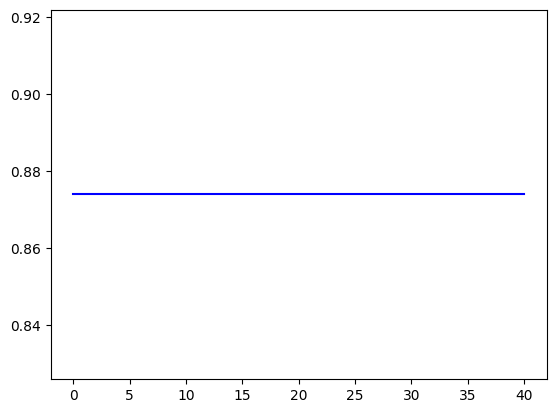

In [93]:
# dependence on oxygen
n_points = 20
O2vec = np.linspace(0,40, n_points)
vgro = np.zeros(O2vec.size)  # initalize vector of growth rates
vacet = np.zeros(O2vec.size) # vector of acetate
original_ub = model.reactions.EX_o2_e.upper_bound  # original lower bound

# loop on all O2 upper bounds
for j in range(0,O2vec.size):
    model.reactions.EX_o2_e.upper_bounds = 0
    model.reactions.EX_o2_e.lower_bounds = -1

    # RUN FBA
    solution = model.optimize()
    vgro[j] = solution.objective_value  # save the growth rate for this O2 condition
    vacet[j]=solution.fluxes.EX_ac_e

    print(f"O2 exchange: {solution.fluxes['EX_o2_e']}")
    # print(j,O2vec[j],vgro[j],vacet[j])

# return to original
# model.reactions.EX_o2_e.lower_bound = original_lb

# plot
ax = plt.subplot(111)
ax.plot(O2vec,vgro,'b')

In [90]:
original_ub

1000.0